In [1]:
import numpy as np

from tqdm.auto import trange, tqdm
import matplotlib.pyplot as plt

import tensorflow as tf
# import tensorflow_datasets as tfds
from tensorflow.keras import layers

c:\Users\megav\anaconda3\envs\iml-10\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [14]:
dataset = tf.keras.preprocessing.image_dataset_from_directory(
    "../data/data0/lsun/bedroom",
    labels=None,
    label_mode=None,
    class_names=None,
    color_mode='rgb',
    batch_size=None,
    image_size=(128, 128),
    shuffle=True,
    seed=2024,
    validation_split=None,
    subset=None,
    interpolation='bilinear',
    follow_links=False,
    crop_to_aspect_ratio=False
).take(150000)


Found 303125 files belonging to 1 classes.


In [16]:
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  1


In [3]:
IMG_SIZE = 128    # input image size
BATCH_SIZE = 8  # for training batch size
timesteps = 16    # how many steps for a noisy image into clear
time_bar = 1 - np.linspace(0, 1.0, timesteps + 1) # linspace for timesteps

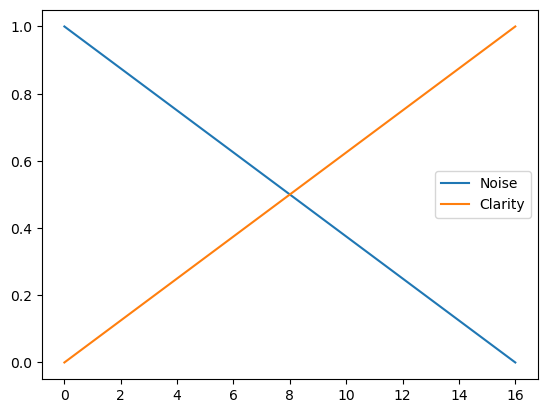

In [18]:
plt.plot(time_bar, label='Noise')
plt.plot(1 - time_bar, label='Clarity')
plt.legend()

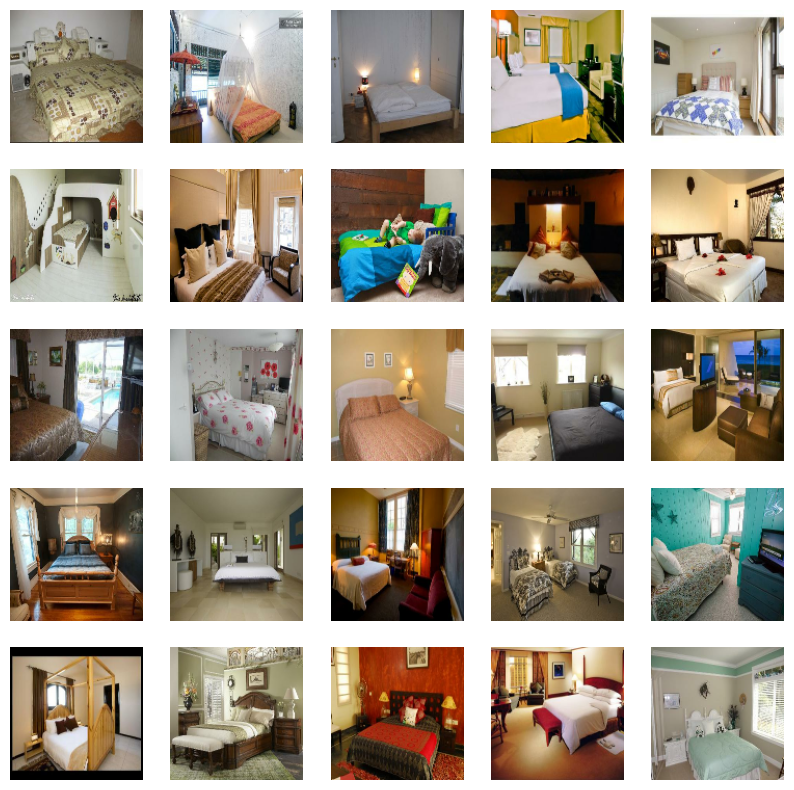

In [4]:
def cvtImg(img):
    img = img - img.min()
    img = (img / img.max())
    return img.astype(np.float32)

def show_numpy_examples(x):
    plt.figure(figsize=(10, 10))
    for i in range(25):
        plt.subplot(5, 5, i+1)
        img = cvtImg(x[i])
        plt.imshow(img)
        plt.axis('off')

show_numpy_examples(np.array(list(dataset.take(25))))

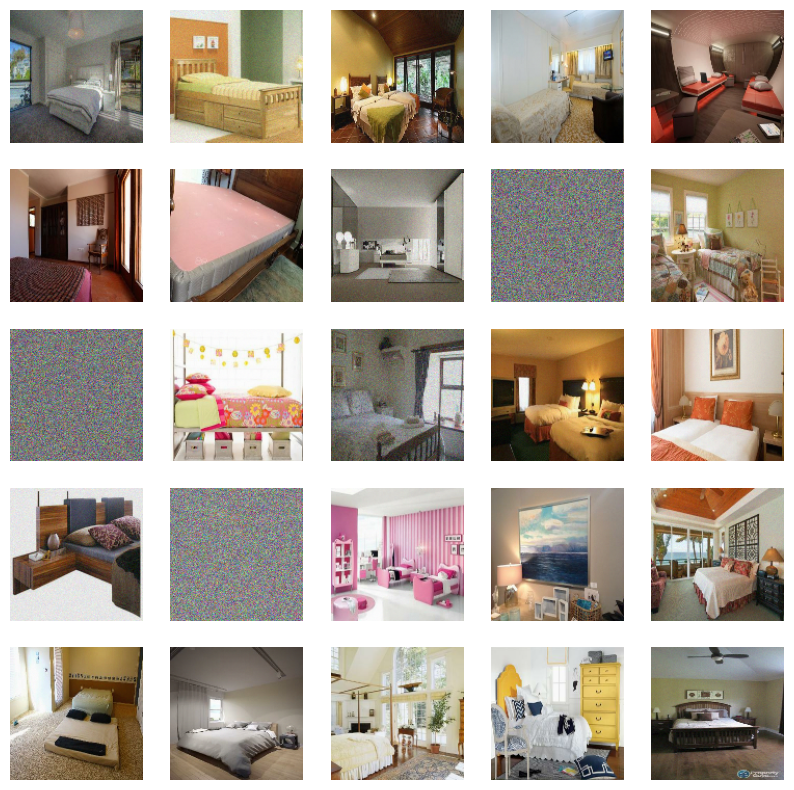

In [5]:
def forward_noise(x, t):
    a = time_bar[t]      # base on t
    b = time_bar[t + 1]  # image for t + 1
    
    noise = np.random.normal(size=x.shape)  # noise mask
    a = a.reshape((-1, 1, 1, 1))
    b = b.reshape((-1, 1, 1, 1))
    img_a = x * (1 - a) + noise * a
    img_b = x * (1 - b) + noise * b
    return img_a, img_b
    
def generate_ts(num):
    return np.random.randint(0, timesteps, size=num)

# t = np.full((25,), timesteps - 1) # if you want see clarity
# t = np.full((25,), 0)             # if you want see noisy
t = generate_ts(25)             # random for training data
a, b = forward_noise(np.array(list(dataset.take(25))), t)
show_numpy_examples(a)

In [6]:
def block(x_img, x_ts):
    x_parameter = layers.Conv2D(128, kernel_size=3, padding='same')(x_img)
    x_parameter = layers.Activation('relu')(x_parameter)

    time_parameter = layers.Dense(128)(x_ts)
    time_parameter = layers.Activation('relu')(time_parameter)
    time_parameter = layers.Reshape((1, 1, 128))(time_parameter)
    x_parameter = x_parameter * time_parameter
    
    # -----
    x_out = layers.Conv2D(128, kernel_size=3, padding='same')(x_img)
    x_out = x_out + x_parameter
    x_out = layers.LayerNormalization()(x_out)
    x_out = layers.Activation('relu')(x_out)
    
    return x_out

In [7]:
def make_model():
    x = x_input = layers.Input(shape=(IMG_SIZE, IMG_SIZE, 3), name='x_input')
    
    x_ts = x_ts_input = layers.Input(shape=(1,), name='x_ts_input')
    x_ts = layers.Dense(192)(x_ts)
    x_ts = layers.LayerNormalization()(x_ts)
    x_ts = layers.Activation('relu')(x_ts)
    
    # ----- left ( down ) -----
    x = x32 = block(x, x_ts)
    x = layers.MaxPool2D(2)(x)
    
    x = x16 = block(x, x_ts)
    x = layers.MaxPool2D(2)(x)
    
    x = x8 = block(x, x_ts)
    x = layers.MaxPool2D(2)(x)
    
    x = x4 = block(x, x_ts)
    
    # ----- MLP -----
    x = layers.Flatten()(x)
    x = layers.Concatenate()([x, x_ts])
    x = layers.Dense(128)(x)
    x = layers.LayerNormalization()(x)
    x = layers.Activation('relu')(x)

    x = layers.Dense(16 * 16 * 128)(x)
    x = layers.LayerNormalization()(x)
    x = layers.Activation('relu')(x)
    x = layers.Reshape((16, 16, 128))(x)
    
    # ----- right ( up ) -----
    x = layers.Concatenate()([x, x4])
    x = block(x, x_ts)
    x = layers.UpSampling2D(2)(x)
    
    x = layers.Concatenate()([x, x8])
    x = block(x, x_ts)
    x = layers.UpSampling2D(2)(x)
    
    x = layers.Concatenate()([x, x16])
    x = block(x, x_ts)
    x = layers.UpSampling2D(2)(x)
    
    x = layers.Concatenate()([x, x32])
    x = block(x, x_ts)
    
    # ----- output -----
    x = layers.Conv2D(3, kernel_size=1, padding='same')(x)
    model = tf.keras.models.Model([x_input, x_ts_input], x)
    return model

model = make_model()
# model.summary()

In [8]:
optimizer = tf.keras.optimizers.Adam(learning_rate=0.0008)
loss_func = tf.keras.losses.MeanAbsoluteError()
model.compile(loss=loss_func, optimizer=optimizer)

100%|██████████| 16/16 [00:05<00:00,  2.94it/s]


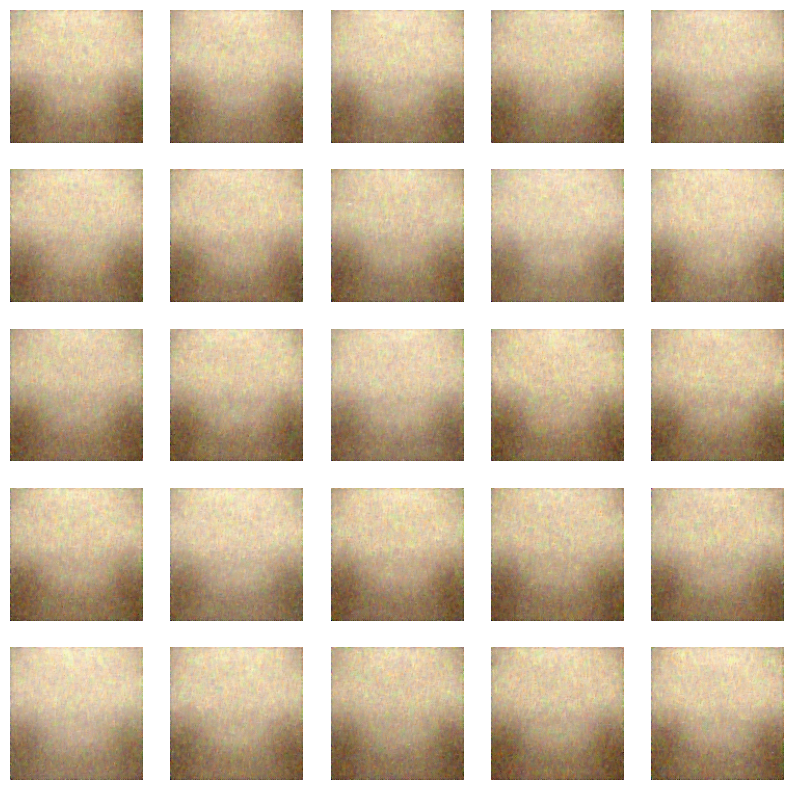

In [16]:
# def predict(x_idx=None):
#     x = np.random.normal(size=(32, IMG_SIZE, IMG_SIZE, 3))
#     for i in trange(timesteps):
#         t = i
#         x = model.predict([x, np.full((32), t)], verbose=0)
#     show_numpy_examples(x)

predict()

In [10]:
def predict_step():
    xs = []
    x = np.random.normal(size=(8, IMG_SIZE, IMG_SIZE, 3))

    for i in trange(timesteps):
        t = i
        x = model.predict([x, np.full((8),  t)], verbose=0)
        if i % 2 == 0:
            xs.append(x[0])

    plt.figure(figsize=(20, 2))
    for i in range(len(xs)):
        plt.subplot(1, len(xs), i+1)
        plt.imshow(cvtImg(xs[i]))
        plt.title(f'{i}')
        plt.axis('off')

# predict_step()

In [11]:
def train_one(x_img):
    x_ts = generate_ts(len(x_img))
    x_a, x_b = forward_noise(x_img, x_ts)
    # print(x_a.shape)
    # print(x_b.shape)
    # print(x_ts.shape)
    loss = model.train_on_batch([x_a, x_ts], x_b)
    return loss

In [12]:
loss_history = []

def train(dataset):
    total = dataset.cardinality().numpy()
    bar = trange(total)
    print(bar)
    batch_iterator = iter(dataset)
    for i in bar:
        batch = next(batch_iterator)
        loss = train_one(batch.numpy())
        # loss_history.append(loss)
        pg = (i / total) * 100
        bar.set_description(f'loss: {loss:.5f}, p: {pg:.2f}%')

# dataset8 = dataset.batch(8)
# train(dataset8)

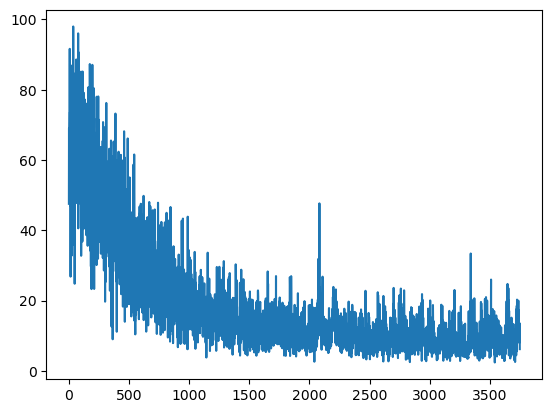

In [30]:
plt.plot(loss_history)
# plt.title('Training loss')


  0%|          | 0/18750 [00:00<?, ?it/s]

  0%|          | 0/18750 [00:00<?, ?it/s]


100%|██████████| 16/16 [00:01<00:00,  9.09it/s]


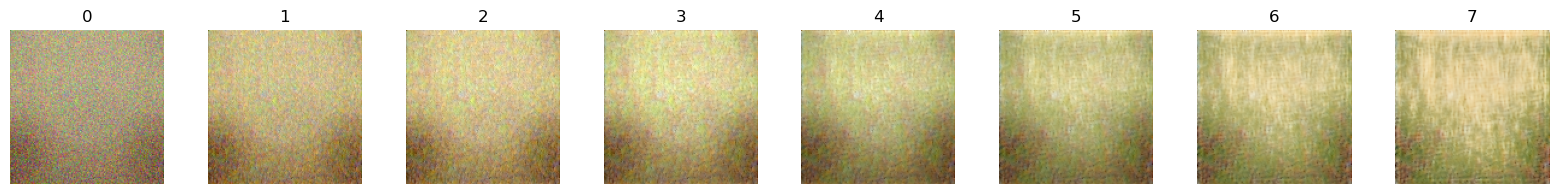

  0%|          | 0/18750 [00:00<?, ?it/s]

  0%|          | 0/18750 [00:00<?, ?it/s]


100%|██████████| 16/16 [00:01<00:00, 11.99it/s]


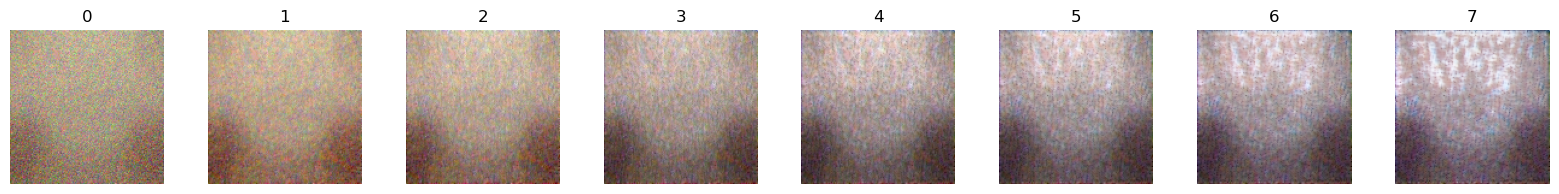

  0%|          | 0/18750 [00:00<?, ?it/s]

  0%|          | 0/18750 [00:00<?, ?it/s]


100%|██████████| 16/16 [00:01<00:00, 12.20it/s]


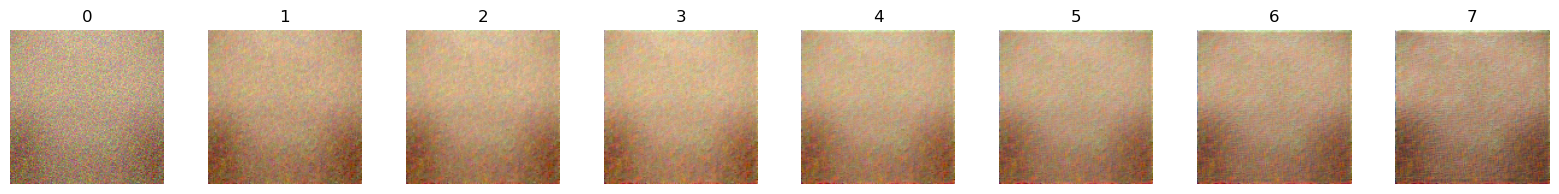

  0%|          | 0/18750 [00:00<?, ?it/s]

  0%|          | 0/18750 [00:00<?, ?it/s]


100%|██████████| 16/16 [00:01<00:00, 11.95it/s]


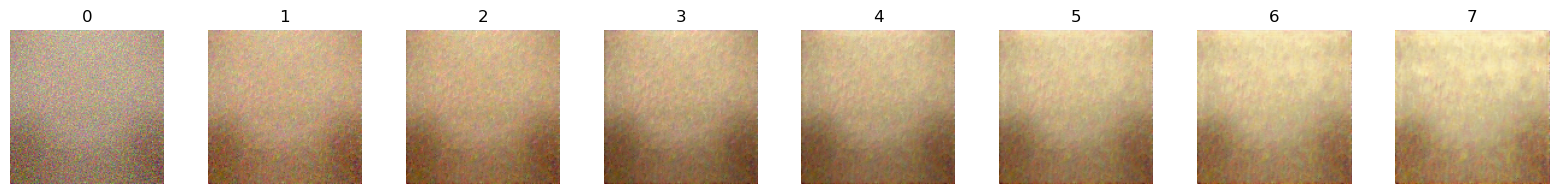

  0%|          | 0/18750 [00:00<?, ?it/s]

  0%|          | 0/18750 [00:00<?, ?it/s]


100%|██████████| 16/16 [00:01<00:00, 11.97it/s]


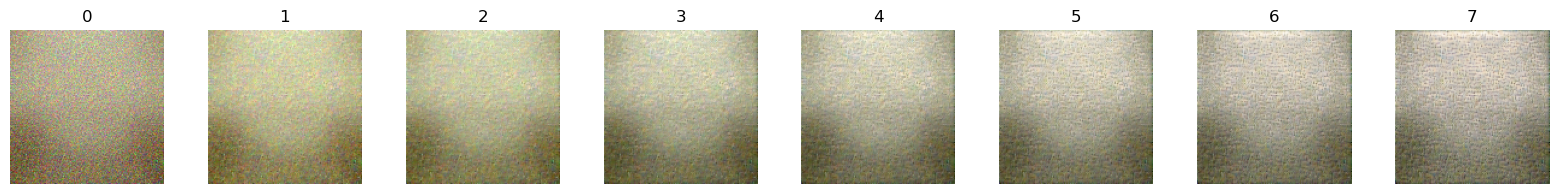

  0%|          | 0/18750 [00:00<?, ?it/s]

  0%|          | 0/18750 [00:00<?, ?it/s]


100%|██████████| 16/16 [00:01<00:00, 12.06it/s]


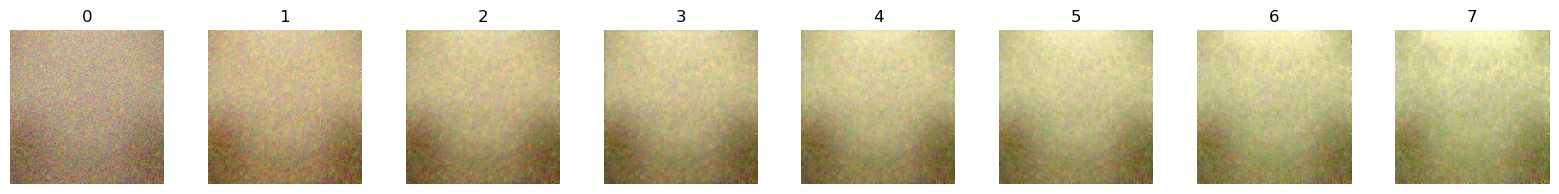

  0%|          | 0/18750 [00:00<?, ?it/s]

  0%|          | 0/18750 [00:00<?, ?it/s]


100%|██████████| 16/16 [00:01<00:00, 12.02it/s]


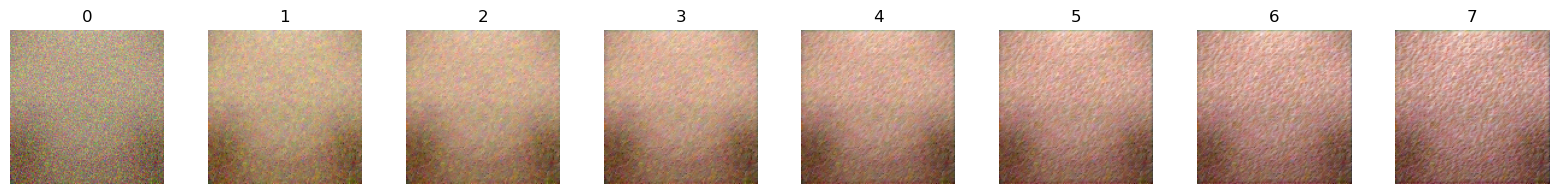

  0%|          | 0/18750 [00:00<?, ?it/s]

  0%|          | 0/18750 [00:00<?, ?it/s]


100%|██████████| 16/16 [00:01<00:00, 12.14it/s]


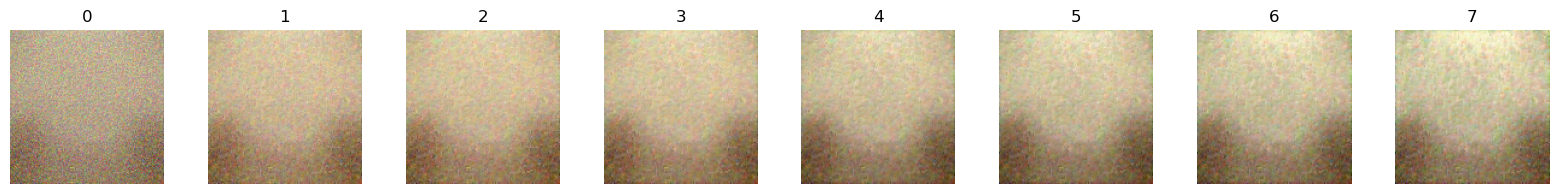

  0%|          | 0/18750 [00:00<?, ?it/s]

  0%|          | 0/18750 [00:00<?, ?it/s]


100%|██████████| 16/16 [00:01<00:00, 11.93it/s]


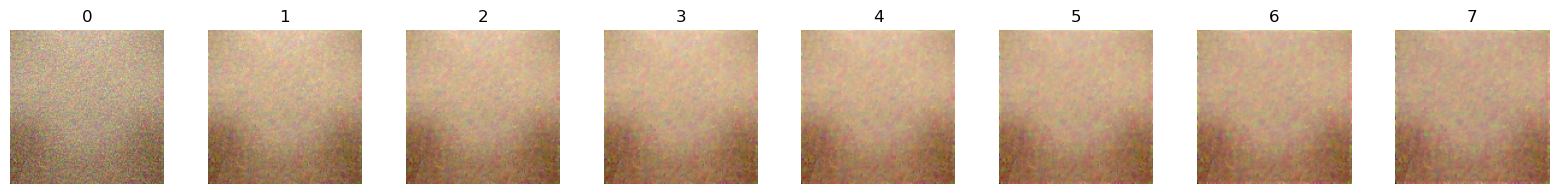

  0%|          | 0/18750 [00:00<?, ?it/s]

  0%|          | 0/18750 [00:00<?, ?it/s]


100%|██████████| 16/16 [00:01<00:00, 12.03it/s]


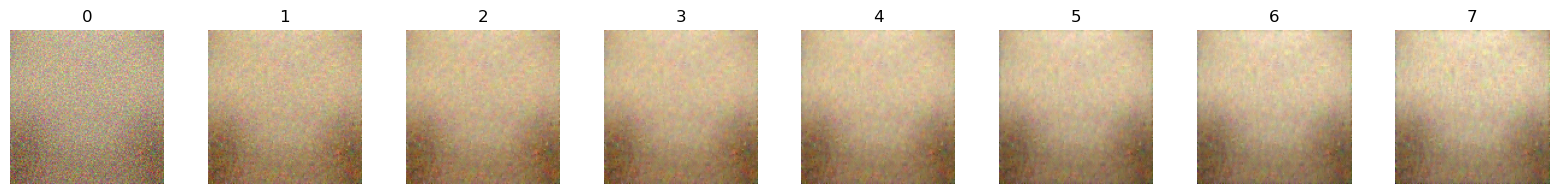

In [15]:
dataset8 = dataset.batch(8)

for _ in range(10):
    train(dataset8)
    # reduce learning rate for next training
    model.optimizer.learning_rate = max(0.000001, model.optimizer.learning_rate * 0.9)

    # show result 
    # predict()
    predict_step()
    plt.show()